In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import numpy as np

from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_armonk')
# from qiskit.test.mock import FakeLondon
# machine = FakeLondon()
machine_noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')


basis_gates = machine_noise_model.basis_gates

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Adding U3 Pairs

In [2]:
def splitter(word): 
    return [char for char in word] 


In [3]:
import math 

def PiReader(string):
    '''
    Converts symbol experession to numerical answer
    
    Assumption: should not contain decimal
    '''
    
    #null case 
    if string == "0" or string == "0.0": 
        return 0
    
    temp = []
    expression = 1
    
    arry = splitter(string)
    i = 0
    
    while (i<len(arry)): 
        element = arry[i]

        #number
        if element.isdigit():
            
            number = int(element)
            i+=1
#             #to make sure 2,3,.. digit case is accounted for
#             while(arry[i].isdigit()):
#                 number = number*10 +int(arry[i])
#                 i+=1
#             #finally multiplying by the number
            expression*=number
            
        #negative sign 
        elif element == '-':
            expression *= -1
            i+=1
            
        #pi 
        elif element == 'p':
            expression *= math.pi
            i+=2   #skip the 'i'
            
        #division sign
        elif element == "/": 
            expression/= int(arry[i+1])
            i+=2
            
        #do nothing if mult sign
        elif element == "*":
            expression = expression
            i+=1
        else:
            print('Erront in parsing angle.... char is ' + element)
            expression*=1
            i+=1

    return expression

In [4]:
import math 

def u3PairAdder(orig_gate_str, barrier): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    # Converting the gate string to array 
#     print('original string is ' + orig_gate_str)
    ##break up the string 
    strings = orig_gate_str.split("(")
    temp =[]
    for string in strings: 
        temp = temp + string.split(")")
    strings = temp 
    temp =[]
    for string in strings: 
        temp = temp + string.split(",")
    strings = temp 
#     temp = []
#     for string in strings: 
#         temp = temp + string.split("*")
    strings = temp
    
    #Obtaining all useful information 
    gate = strings[0]
    qubit = strings[4]
#     print( '---------------------------------------')
#     print ('Strings is ')
#     print(strings)
#     print('---------------------------------------')
    orig_angles = strings[1:4]
    
    #new angles 
    new_angles = orig_angles 
    
    ## U3 ^-1(  theta,  phi, lambda) = U3( theta , -pi - lambda, - pi - phi)
    
    ###Part 1: adding - pi to  - of 2nd and 3rd angle
    for i in range(1,3): 
        
        if 'pi' in new_angles[i]: 
            angle = PiReader(new_angles[i])
        else: 
            angle = float(new_angles[i])
            
            
        new_angles[i] = str(-math.pi - angle)
        
#         if new_angles[i][0] == '-': 
            
#             if new_angles[i] == '-pi': 
#                 new_angles[i] = str(-math.pi +math.pi)
#             elif new_angles[i] == '-pi/2': 
#                 new_angles[i] = str(-math.pi +(math.pi/2))
#             else:
#                 new_angles[i] = str(-math.pi +float(new_angles[i][1:]))
#         else: 
#             if new_angles[i] == 'pi': 
#                 new_angles[i] = str(-math.pi -math.pi)
#             elif new_angles[i] == 'pi/2': 
#                 new_angles[i] = str(-math.pi -(math.pi/2))
#             else:
#                 new_angles[i] = str(-math.pi+ (-1)*float(new_angles[i]))

    ###Part 2: Switching the 2nd and 3rd angles
    new_angles = [new_angles[0], new_angles[2], new_angles[1]]
            

    #creating inverted gate
    new_gate_str = gate + '(' + new_angles[0] + ',' + new_angles[1] + ',' + new_angles[2] + ')' + qubit
    
    #barrier 
    #barrier ="""barrier q[0],q[1];"""
    
    return barrier + '\n' + new_gate_str + '\n'+ barrier + '\n' + orig_gate_str + '\n' + barrier + '\n' + new_gate_str + '\n'+ barrier + '\n' + orig_gate_str + '\n' + barrier + '\n'
    

## Adding CNOT pairs

In [5]:
def cXPairAdder(orig_gate_str, barrier): 
    """
    Input: a qasm string corresponding to a gate
    Output: a pair of gates in qasm string representation to amplify error in the given gate by factor of 3
    """
    #barrier for 2 qubit circuit only
    #barrier ="""barrier q[0],q[1];"""
    
    return barrier + '\n' + orig_gate_str +'\n' +barrier + '\n'+orig_gate_str + '\n' + barrier + '\n' + orig_gate_str +'\n' +barrier + '\n'+orig_gate_str + '\n' + barrier + '\n'

## Gate Insertion Function

In [6]:
import random 
debug = []

def GateInsertion(circ, c): 
    """
    Input: a circuit (with u3 and cnot gates only), and scaling factor
    Output: circuit with amplified error using gate insertion
    """
    #for creating barriers!
    n_qubits = circ.num_qubits
    qubit_str = ""
    if (n_qubits == 1): qubit_str= "qr[0]"
    elif (n_qubits == 2): qubit_str= "q[0],q[1]"
    
    barrier = "barrier " + qubit_str + ";"
    
    #iterating over the circuit in string representation
    
    
    newqasm_str=""
    circ_str=circ.qasm()
#     print("Converting circ to string using Qasmstring function in Quantum Ciruit")
#     print(circ_str)
    
    qregname=circ.qregs[0].name
    global debug 
    debug = []
    
    for line in iter(circ_str.splitlines()):
        
        if line.startswith('cx') or line.startswith('u3'):
            
            #adding the original first
            newqasm_str+= barrier + '\n' + line + '\n'+ barrier + '\n'
            
            #doing a toss to see number of identities:
            n_ident_mean= (c-1)/2
            n_ident = np.random.poisson(n_ident_mean, 1)[0]
            debug.append(n_ident)
            
            #adding those identities
            for i in range(n_ident):  
                
                if line.startswith('cx'):
                    newqasm_str += cXPairAdder(line, barrier)
                else:
                    newqasm_str += u3PairAdder(line, barrier)
        else:
            newqasm_str+=line+"\n"
#     print("------------------------------------")
#     print("passing a modified qasm string to from_qasm_str method of quantum circuit")
#     print(newqasm_str)https://notebooks.quantum-computing.ibm.com/user/5d10d2fd29bc3e00182cd85c/notebooks/Gate%20Insertion%20with%20Poisson%20.ipynb#

    circo=QuantumCircuit().from_qasm_str(newqasm_str)
    
    return circo 


## Randomized Benchmarking

In [7]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

In [8]:
#Generate RB circuits (2Q RB)

#number of qubits
nQ=1
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1] +[10*i for i in range(1, 16)]
#Number of seeds (random sequences)
rb_opts['nseeds'] =1
#Default pattern
rb_opts['rb_pattern'] = [[0]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

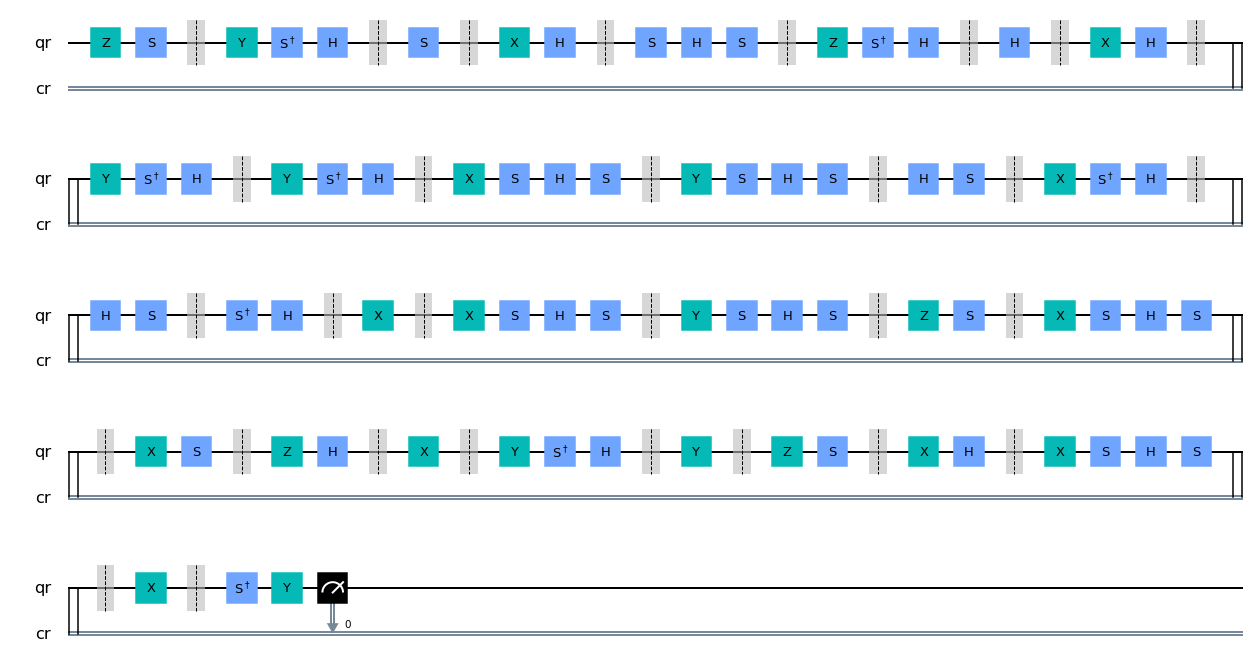

In [9]:
rb_circs[0][3].draw(output = 'mpl')

In [10]:
# converting everything to u3

from qiskit.compiler import transpile
basis_gates =  ['id', 'u3']

rb_u3_circs = []

for i in range(len(rb_circs)): 
    seed_circs = []
    for j in range(len(rb_circs[i])): 
        transpiled_circ = transpile(rb_circs[i][j], basis_gates = basis_gates)
        seed_circs.append(transpiled_circ)
    rb_u3_circs.append(seed_circs)


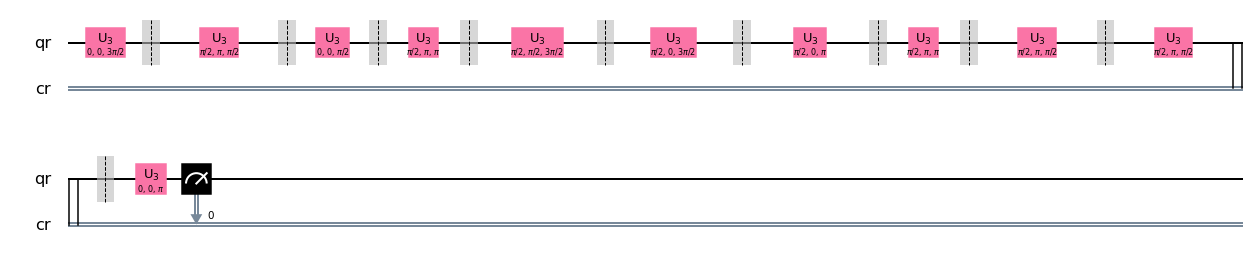

In [11]:
rb_u3_circs[0][1].draw(output = 'mpl')

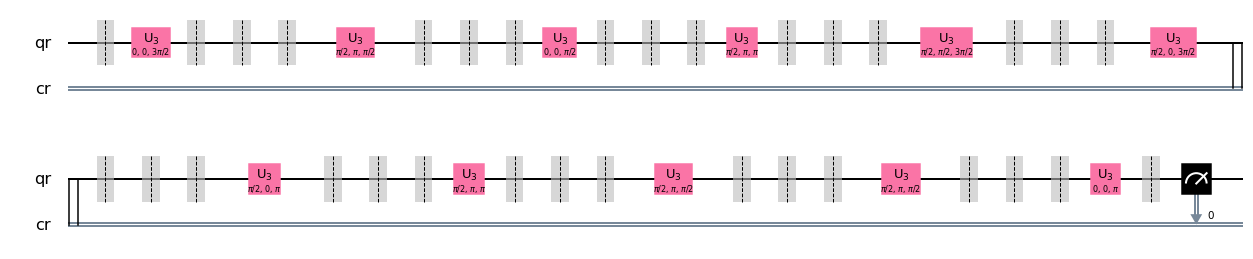

In [12]:
circ = GateInsertion(rb_u3_circs[0][1], 1.1)
circ.draw(output = 'mpl')

In [13]:
#scaling circuits 
scaled_circuits = []   # buckets are scales, each contains seeds which contain circs

scales = [1,1.1, 1.2, 1.3]
for c in scales:
    scale_seeds = []
    for seed in rb_u3_circs: 
        new_seed =[]
        for circ in seed: 
            scaled_circ =  GateInsertion(circ,c)
            new_seed.append(scaled_circ)
        scale_seeds.append(new_seed)
    scaled_circuits.append(scale_seeds)

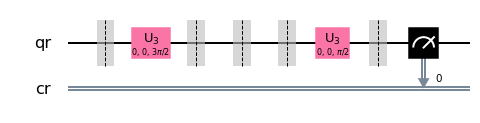

In [14]:
scaled_circuits[2][0][0].draw(output='mpl')

## Results

In [15]:
def countsToProb(counts, sample_size): 
    '''
    Input: counts 
    Output: prob 
    '''
    return (counts['0']/sample_size)

In [16]:
def averagingSeeds(seeds):
    '''
    Input: list of seed probs - buckets are seeds, each with prob for particular gate length
    Output: a single list of probs of gate lengths (averaging across all seeds)
    '''
    gate_lengths = len(seeds[0])
    n_seeds = len(seeds)
    
    
    result =[] # contain averaged out probs of gate lengths
    
    for i in range(gate_lengths):
        summ = 0
        for j in range(n_seeds): 
            summ += seeds[j][i]
        summ/= n_seeds 
        result.append(summ)
        
    return result
    

In [18]:
def addDicts(listy): 
    '''
    Input: list of dicts of counts 
    Output: combining all dicts into one dict, returning that
    '''
    keys = ['0', '1']
    master = {}
    
    for key in keys: 
        #initializing master at that key
        master[key] = 0
        
        #now adding up all dictys[key]
        for dicty in listy: 
            try:
                master[key] += dicty[key]
            except KeyError: 
                continue
    return master

In [35]:
def runExperiments(circuits, backend, sample_size):
    '''
    Input: List of circuits organized as follows: scales ---> seeds-----> circuits
    Output: List of counts in that same order after executing all circuits at synchronously
    '''
    n_scales = len(circuits)
    n_seeds = len(circuits[0])
    n_gate_lengths = len(circuits[0][0])
    
    #collecting all circuits
    experiments = []
    
    for i in range(n_scales): 
        for j in range(n_seeds):
            for k in range(n_gate_lengths): 
                experiments.append(circuits[i][j][k])
                
    #Executing all experiments 
    counts = []
    while (sample_size !=0):
        sample_counts = []
        if (sample_size>8192):
            job = execute(experiments, backend, shots=8192)
            job_monitor(job)
            result = job.result()
            sample_counts = result.get_counts()
            sample_size-=8192
        else: 
            job = execute(experiments, backend, shots=sample_size)
            job_monitor(job)
            result = job.result()
            sample_counts = result.get_counts()
            sample_size = 0
        
        if(len(counts)!=0):
            #adding up results of this with all 
            new_counts = []
            for i in range(len(counts)): 
                dicty = addDicts([counts[i], sample_counts[i]])
                new_counts.append(dicty)
            counts = new_counts
        else: 
            counts = sample_counts
    
    new_counts = []
    
    for i in range(n_scales): 
        scale_counts = []
        print('--------------------------------------------------New Scale')
        
        for j in range(n_seeds): 
            seed_counts = []
            print('----------------------New Seed')
            
            for k in range(n_gate_lengths): 
                print('-- Gate Length ')
                count  = counts[i*(n_seeds*n_gate_lengths) + j*(n_gate_lengths) + k]
                seed_counts.append(count)
            scale_counts.append(seed_counts)
        new_counts.append(scale_counts)
    
    return new_counts

In [37]:
#running the jobs 
Probs = [] # buckets are scales, each of which contain probs for various gate lengths 

from qiskit.tools.monitor import job_monitor
Probs = []

sample_size = 100000

#running all experiments 
counts = runExperiments(scaled_circuits, machine, sample_size)
print('counts are -----------------------------------------------------------------------------------------------')
print(counts)

for scale_seeds in counts:
    scale_probs = [] # initailly buckets are seeds
    for seed in scale_seeds: 
        seed_probs = []
        for gate_count in seed:
            print(gate_count)
            prob= countsToProb(gate_count, sample_size)
            seed_probs.append(prob)
        scale_probs.append(seed_probs)
    #averaging probs across all seeds 
    scale_probs = averagingSeeds(scale_probs) #now buckets are gate length prob (bucket are scalar here)
    Probs.append(scale_probs)
    

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
--------------------------------------------------New Scale
----------------------New Seed
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
--------------------------------------------------New Scale
----------------------New Seed
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-- Gate Length 
-

## Plotting Results

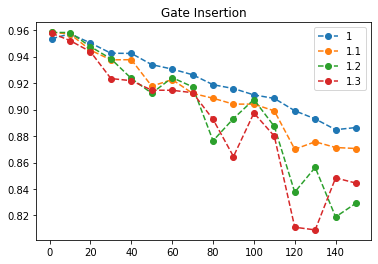

In [38]:
import matplotlib.pyplot as plt 

a = plt.figure()

for scale in range(len(Probs)): 
    plt.plot(rb_opts['length_vector'], Probs[scale], marker = 'o', linestyle= '--', label = str(scales[scale]))
plt.title('Gate Insertion')
plt.legend()
plt.show()
a.savefig("plotSep30(1).png", dpi = 1000)